# GPT 모델을 구성해보자

## Transformer와 비교해 변경이 필요한 부분 서술

- GPT 모델에서는 Decoder만 사용하므로, Encoder의 모든 부분은 삭제한다.
- Decoder의 input에서 positional encoding을 positional embedding으로 변경한다.(positional encoding은 sin, cos으로 고정, positiona embedding은 학습 가능하다)
- Encoder가 없으므로 encoder-decoder attension layer를 제거한다.

model summary. 
![summary](./model_summary.png)
model fit. 
![fit](./model_fit.png)

## 모델의 입력 형태에 맞게 전처리

### import labrary

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 데이터 가져오기

In [2]:
data_path = os.environ.get("HOME") + "/aiffel/transformer_chatbot/data/ChatbotData.csv"
df_data = pd.read_csv(data_path)
df_data = df_data[['Q','A']]
df_data.sample(5)

,Q,A
3476,요즘 드라마가 땡겨,저도 드라마 좋아해요.
9962,사랑하는 사람이랑 결혼하고싶어,언젠가 그런 사람이 당신 옆에 있을거예요.
7443,이별 중독,슬픈 단어네요.
7944,저는 개인적으로 따로 연락하자는분들.,부담스러운가봅니다.
6270,매번 왜 이렇게 남는게 후회인지 모르겠네 ㅎㅎ,모든 일에는 후회가 남기 마련인가봐요.


In [3]:
df_data.isnull().sum()

Q    0
A    0
dtype: int64

In [4]:
duplicates = df_data[df_data.duplicated( keep=False)]
duplicates.sort_values(by=['Q','A'])

,Q,A
152,결혼이나 하지 왜 자꾸 나한테 화 내냐구!,힘들겠네요.
5527,결혼이나 하지 왜 자꾸 나한테 화 내냐구!,힘들겠네요.
189,고백하고 후회하면 어떡하지,후회는 후회를 낳을뿐이에요. 용기 내세요.
5537,고백하고 후회하면 어떡하지,후회는 후회를 낳을뿐이에요. 용기 내세요.
226,공부는 내 체질이 아닌 것 같아,확신이 없나봐요.
...,...,...
8780,회사 사람들이 아직도 불편해,회사에는 동료가 있을 뿐이에요.
5232,회사에는 왜 친구 같은 사람이 없을까,회사는 친구 사귀는 곳이 아니에요.
8782,회사에는 왜 친구 같은 사람이 없을까,회사는 친구 사귀는 곳이 아니에요.
5246,후련하달까,후련하니 다행이에요.


In [5]:
# Q와 A 모두 중복인 경우 마지막 행을 drop
df_unique = df_data.drop_duplicates(keep='first')

In [6]:
# 확인
df_unique[df_unique.duplicated( keep=False)].sort_values(by=['Q'])

,Q,A


In [7]:
print("중복 제거 전: ",df_data.shape)
print("중복 제거 후: ",df_unique.shape)

중복 제거 전:  (11823, 2)
중복 제거 후:  (11750, 2)


In [8]:
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower().strip()    

    # 단어와 구두점 사이 거리 두기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    # 연속된 공백 -> 하나의 공백
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, 0-9, 가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r'[^a-zA-Z0-9가-힣\.\?\!\,]', ' ', sentence)
    
    # 양쪽 공백 제거
    sentence = sentence.strip()
    return sentence

In [9]:
df_preprocessed = pd.DataFrame()

In [10]:
df_preprocessed['Q'] = df_unique['Q'].apply(preprocess_sentence)
df_preprocessed['A'] = df_unique['A'].apply(preprocess_sentence)

In [11]:
df_preprocessed.head()

,Q,A
0,12시 땡 !,하루가 또 가네요 .
1,1지망 학교 떨어졌어,위로해 드립니다 .
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .
4,ppl 심하네,눈살이 찌푸려지죠 .


numpy 배열로 변환

In [12]:
questions = df_preprocessed['Q'].values
answers = df_preprocessed['A'].values

In [13]:
print(questions.shape)
print(type(questions))
print(questions[0])
print(answers.shape)
print(type(answers))
print(answers[0])

(11750,)
<class 'numpy.ndarray'>
12시 땡 !
(11750,)
<class 'numpy.ndarray'>
하루가 또 가네요 .


### tokenizing

In [14]:
import tensorflow_datasets as tfds

# SubwordTextEncoderfh 토크나이징, questions와 answers를 더한 말뭉치를 기반으로 학습하여 토크나이징
# 토큰의 갯수는 2**13 = 8192개 를 만들도록 시도
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions+answers, target_vocab_size=2**13)

입력을 시퀀스 형태로 만들기 위해 DELIMETER 토큰을 추가한다   

In [15]:
# start_token, end_token 추가; 위에서 8192[0~8191]개의 토큰이 생성을 시도했고, 
# 그 다음 인텍스로 start_token, end_token을 지정
# []를 추가하는 이유? 토큰 시퀀스와 +연산으로 붙이기 편하게 하기 위해(리스트 합)

START_TOKEN, DELIMETER, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1], [tokenizer.vocab_size+2]

In [16]:
# 2**13개 토큰 시도 결과로 8318개 만들어짐
print("START_TOKEN: ",START_TOKEN)
print("DELIMETER: ", DELIMETER)
print("END_TOKEN: ", END_TOKEN)

START_TOKEN:  [8318]
DELIMETER:  [8319]
END_TOKEN:  [8320]


In [17]:
# 단어장 크기 설정 -> start_token, delimeter, end_token 추가
VOCAB_SIZE = tokenizer.vocab_size + 3
print(VOCAB_SIZE)

8321


In [18]:
# 토크나이징 확인, 인코딩 확인
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5821, 605, 2491, 4166]
정수 인코딩 후의 21번째 답변 샘플: [2682, 7632, 9, 6351, 94, 1]


### 문장 길이 분포 확인

### decoder input

sos + question + delimeter + answer + eos

질문의 최소 길이 : 1
질문의 최대 길이 : 16
질문의 평균 길이 : 3.9406808510638296
답변의 최소 길이 : 1
답변의 최대 길이 : 24
답변의 평균 길이 : 4.716595744680851


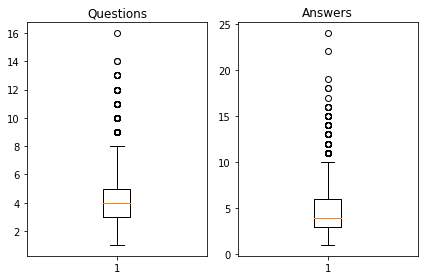

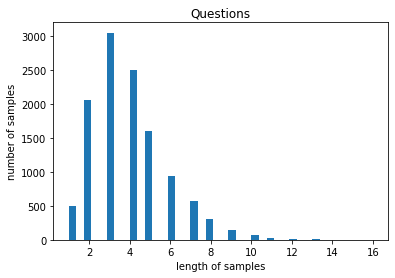

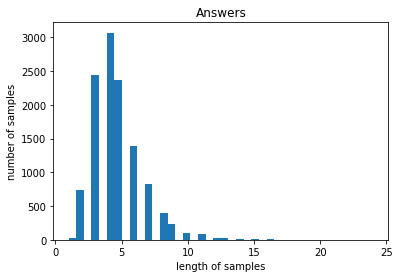

In [19]:
# 혼란한 matplotlib 코드 -> 객체지향적으로 바꿔야 함
# 길이 분포 출력
import matplotlib.pyplot as plt

questions_len= [len(s.split()) for s in questions ]
answers_len = [len(s.split()) for s in answers ]

print('질문의 최소 길이 : {}'.format(np.min(questions_len)))
print('질문의 최대 길이 : {}'.format(np.max(questions_len)))
print('질문의 평균 길이 : {}'.format(np.mean(questions_len)))
print('답변의 최소 길이 : {}'.format(np.min(answers_len)))
print('답변의 최대 길이 : {}'.format(np.max(answers_len)))
print('답변의 평균 길이 : {}'.format(np.mean(answers_len)))

plt.subplot(1,2,1)
plt.boxplot(questions_len)
plt.title('Questions')
plt.subplot(1,2,2)
plt.boxplot(answers_len)
plt.title('Answers')
plt.tight_layout()
plt.show()

plt.title('Questions')
plt.hist(questions_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Answers')
plt.hist(answers_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
input_sequences = []
for question, answer in zip(questions, answers):
    sequence = START_TOKEN + tokenizer.encode(question) \
                    + DELIMETER + tokenizer.encode(answer) \
                    + END_TOKEN
    input_sequences.append(sequence)

In [21]:
sequence_lengths = [len(seq) for seq in input_sequences]


In [22]:
print("최소 길이:", np.min(sequence_lengths))
print("최대 길이:", np.max(sequence_lengths))
print("평균 길이:", np.mean(sequence_lengths))
print("중앙값 길이:", np.median(sequence_lengths))
print("95퍼센타일 길이:", np.percentile(sequence_lengths, 95))


최소 길이: 5
최대 길이: 41
평균 길이: 14.34136170212766
중앙값 길이: 14.0
95퍼센타일 길이: 22.0


In [23]:
print("95퍼센타일 길이:", np.percentile(sequence_lengths, 99))

95퍼센타일 길이: 26.0


26으로 MAX_LENGTH

In [24]:
MAX_LENGTH = 26

In [25]:
input_filtered = []
for sequence in input_sequences:
    if len(sequence) <= 26:
        input_filtered.append(sequence)

In [26]:
print("필터링 전: ",len(input_sequences))
print("필터링 후: ", len(input_filtered))

필터링 전:  11750
필터링 후:  11666


### 패딩

In [27]:
input_padded = tf.keras.preprocessing.sequence.pad_sequences(
      input_sequences, maxlen=MAX_LENGTH, padding='post')

### 데이터 셋 구성

In [28]:
# 한 번에 모델에 입력될 데이터 샘플 수: 64개를 한 묶음으로 보고 병렬처리
BATCH_SIZE = 64
# 셔플을 위한 버퍼 크기 전체 데이터 중 BUFFER_SIZE만큼 메모리에 올려서 셔플하겠다는 것; 메모리 사용량 관리 필요
# 총 데이터가 11750개 정도라...그냥 섞는 메모리 공간을 좀 크게 함.
BUFFER_SIZE = 15000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'dec_inputs': input_padded[:, :-1],
    },
    {
        'outputs': input_padded[:, 1:]
    },
))

dataset = dataset.cache()  # 처음에 메모리에 로딩하고, 이후부터 디스크 I/O 없이 하겠다.
dataset = dataset.shuffle(BUFFER_SIZE)   # 섞어
dataset = dataset.batch(BATCH_SIZE)      # 배치사이즈로 배치 묶음 만들어
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)    # 다음 배치를 백그라운드에서 미리 준비해서 훈련이 끊기지 않도록 함. AUTOTUNE은 TensorFlow가 최적의 prefetch 양을 자동으로 조절해줌 → 성능 최적화


## 모델 구성

In [29]:
from tensorflow.keras import layers

class PositionalEmbedding(layers.Layer):
    def __init__(self, max_length, embedding_dim):
        super(PositionalEmbedding, self).__init__()
        self.pos_embedding = layers.Embedding(
            input_dim=max_length,
            output_dim=embedding_dim
        )

    def call(self, inputs):
        # inputs: (batch_size, seq_len, embedding_dim)
        seq_len = tf.shape(inputs)[1]
        batch_size = tf.shape(inputs)[0]

        positions = tf.range(start=0, limit=seq_len, delta=1)  # (seq_len,)
        positions = tf.expand_dims(positions, 0)               # (1, seq_len)
        positions = tf.tile(positions, [batch_size, 1])        # (batch_size, seq_len)

        pos_embeddings = self.pos_embedding(positions)         # (batch_size, seq_len, embedding_dim)
        return inputs + pos_embeddings                         # broadcasting-safe 덧셈

In [30]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    """
    query와 key의 내적으로 유사도를 구해 -> 행렬로 나옴(셀프어텐션에서만 정사각행렬임)
    코사인 유사도랑 비슷함
    소프트맥스가 너무 커지지 않기 위해 루트(차원)으로 나누어 줌
    소프트맥스를 통과하고 V를 행렬곱
    """
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += mask * -1e9

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output


In [31]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    어텐션을 차원 그룹으로 나누어서 병렬로 수행
    """

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads
        
        # 하나의 입력으로 부터 3개의 표현을 뽑아내기 위해 각각 다른 dense를 사용
        # 입력에 대해서 각각 다른 Dense layer를 통과시켜 서로 다른 관점의 벡터로 선형변환 시킴
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        
        # (batch_size, num_heads, seq_len_q, depth) -> (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs


In [32]:
# 패딩이 어텐션 계산이나 손실 계산에 영향을 주지 않도록 마스킹
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]


In [33]:
# 디코더에서 사용. Q, K 유사도 계산에서, 현재보다 미래 위치 토큰을 가리지 위해 사용.(예측해야 되니까)
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)


In [34]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
#     padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention1)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention1)

    return tf.keras.Model(
        inputs=[inputs,  look_ahead_mask],
        outputs=outputs,
        name=name,
    )




In [35]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    # 패딩 마스크
#     padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEmbedding(MAX_LENGTH, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )([outputs,  look_ahead_mask])

    return tf.keras.Model(
        inputs=[inputs,  look_ahead_mask],
        outputs=outputs,
        name=name,
    )



In [36]:
def GPT(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="gpt"
):

    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")


    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)


    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs,  look_ahead_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[dec_inputs], outputs=outputs, name=name)




In [37]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 12 # 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = GPT(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "gpt"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 512)    23209472    dec_inputs[0][0]                 
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 8321)   4268673     decoder[0][0]                  

In [38]:
# 레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.
# def loss_function(y_true, y_pred):
#     y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

#     loss = tf.keras.losses.SparseCategoricalCrossentropy(
#         from_logits=True, reduction="none"
#     )(y_true, y_pred)

#     mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
#     loss = tf.multiply(loss, mask)

#     return tf.reduce_mean(loss)

def loss_function(y_true, y_pred):
    # y_true: (batch, seq_len)
    # y_pred: (batch, seq_len, vocab_size)

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    # 패딩 마스킹: 0인 부분 제외
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss *= mask

    return tf.reduce_sum(loss) / tf.reduce_sum(mask)



In [39]:
# 학습률을 train step에 따라 변화를 줌
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)



In [41]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# def accuracy(y_true, y_pred):
#   y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
#   return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

def accuracy(y_true, y_pred):
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


In [42]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
184/184 [==============================] - 54s 130ms/step - loss: 8.0808 - accuracy: 0.0413
Epoch 2/50
184/184 [==============================] - 25s 136ms/step - loss: 6.7889 - accuracy: 0.1079
Epoch 3/50
184/184 [==============================] - 25s 135ms/step - loss: 6.2801 - accuracy: 0.1194
Epoch 4/50
184/184 [==============================] - 24s 132ms/step - loss: 5.9622 - accuracy: 0.1245
Epoch 5/50
184/184 [==============================] - 25s 133ms/step - loss: 5.7566 - accuracy: 0.1281
Epoch 6/50
184/184 [==============================] - 25s 134ms/step - loss: 5.5958 - accuracy: 0.1322
Epoch 7/50
184/184 [==============================] - 25s 133ms/step - loss: 5.4430 - accuracy: 0.1369
Epoch 8/50
184/184 [==============================] - 25s 134ms/step - loss: 5.3017 - accuracy: 0.1407
Epoch 9/50
184/184 [==============================] - 25s 134ms/step - loss: 5.1478 - accuracy: 0.1448
Epoch 10/50
184/184 [==============================] - 25s 134ms/step - l

In [62]:
def decoder_inference(input_text):
    input_ids = START_TOKEN + tokenizer.encode(preprocess_sentence(input_text)) + DELIMETER
    output_sequence = tf.expand_dims(input_ids, axis=0)  # shape: (1, seq_len)

    for _ in range(MAX_LENGTH):
        predictions = model(output_sequence, training=False)
        next_token_logits = predictions[:, -1, :]
        predicted_id = tf.argmax(next_token_logits, axis=-1, output_type=tf.int32)

        if predicted_id[0] == END_TOKEN[0]:
            break

        predicted_id = tf.expand_dims(predicted_id, axis=-1)  # shape: (1, 1)
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)


In [63]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )

    print("입력 : {}".format(sentence))
    print("출력 : {}".format(predicted_sentence))

    return predicted_sentence


In [64]:
sentence_generation("퇴사하고 싶어")

입력 : 퇴사하고 싶어
출력 : 퇴사하고 싶어제가 드리고 싶네요 .


'퇴사하고 싶어제가 드리고 싶네요 .'

In [65]:
sentence_generation("퇴사만세")

입력 : 퇴사만세
출력 : 퇴사만세더 열심히 하면 좋겠어요 .


'퇴사만세더 열심히 하면 좋겠어요 .'

In [66]:
sentence_generation("퇴사는게 좋을까?")

입력 : 퇴사는게 좋을까?
출력 : 퇴사는게 좋을까 ?좀 더 많이 다질거 같아요 .


'퇴사는게 좋을까 ?좀 더 많이 다질거 같아요 .'

In [67]:
sentence_generation("퇴사해도 될까?")

입력 : 퇴사해도 될까?
출력 : 퇴사해도 될까 ?전혀 갈 수 있을 거예요 .


'퇴사해도 될까 ?전혀 갈 수 있을 거예요 .'

In [68]:
sentence_generation("쉬고 싶어")

입력 : 쉬고 싶어
출력 : 쉬고 싶어내려 놓으세요 .


'쉬고 싶어내려 놓으세요 .'